<a href="https://colab.research.google.com/github/owlmt/PQC/blob/main/classic_cruptography_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OQS Setup

In [ ]:
!pip install cryptography pyjwt paramiko pycryptodome

In [ ]:
!git clone --depth=1 https://github.com/open-quantum-safe/liboqs
!cmake -S liboqs -B liboqs/build -DBUILD_SHARED_LIBS=ON
!cmake --build liboqs/build --parallel 8
!cmake --build liboqs/build --target install

In [ ]:
# 1. Clone the Python wrapper repository
!git clone --depth=1 https://github.com/open-quantum-safe/liboqs-python

# 2. Change directory into the new folder
%cd liboqs-python

# 3. Install the package
!pip install .

In [ ]:
!sudo ldconfig

In [ ]:
import os

# Point to where you installed liboqs (usually /usr/local/lib by default)
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib'

# Run the KEM (Key Encapsulation Mechanism) example
!python examples/kem.py

In [ ]:
import oqs
import os

# Always ensure the library path is known
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib'

In [ ]:
!pip install nose2

In [ ]:
import os
# Ensure the library path is set for the test runner
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib'

# Run the full test suite
!nose2 --verbose

In [16]:
import oqs
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib'

# Get a list of all enabled signature algorithms
signatures = oqs.get_enabled_sig_mechanisms()

print(f"Total enabled signature schemes: {len(signatures)}")
print(f"A few schemes: {signatures[:3]}")

# Instantiate an algorithm (e.g., the NIST standard ML-DSA-65)
sig_scheme = oqs.Signature("ML-DSA-65")

public_key = sig_scheme.generate_keypair()
message = b"This is a message to be signed."
signature = sig_scheme.sign(message)

print("\n--- Key Pair Generation Complete ---")
print(f"Signature Verification: {sig_scheme.verify(message, signature, public_key)}")

Total enabled signature schemes: 221
A few schemes: ('ML-DSA-44', 'ML-DSA-65', 'ML-DSA-87')

--- Key Pair Generation Complete ---
Signature Verification: True


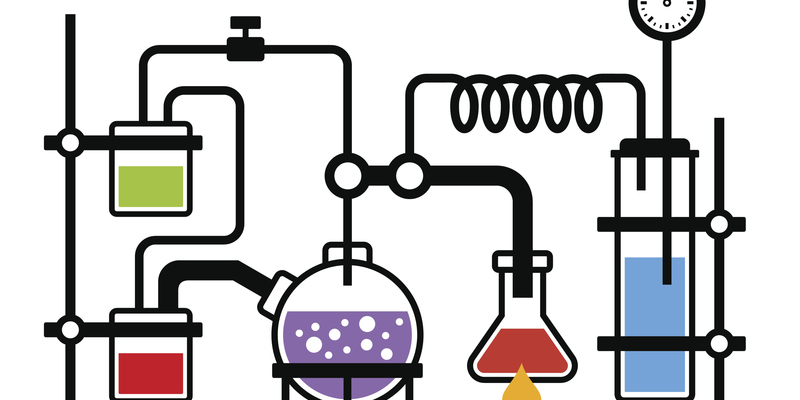

**Research Question:**

Given the same legacy RSA/ECC signing code , which LLMs produce a runnable, cryptographically correct migration to ML-DSA without bugs?

**H₀: There is no difference between LLMs in the probability of producing a correct ML-DSA migration from RSA/ECC.**

**H₁: At least one LLM has a different probability of producing a correct ML-DSA migration.**

Where “correct migration” means:



1.  The code runs without error in a fixed environment
2.  It actually uses ML-DSA (Dilithium) parameters, not RSA/ECDSA.
3. It signs and verifies a message correctly, with a reproducible pass/fail test.




**Task for RSA Signature**

In [17]:
# legacy_rsa_sign.py
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes, serialization

message = b"test message"

private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()

signature = private_key.sign(
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)

public_key.verify(
    signature,
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)

print("OK")


OK


**Task for ECC signature**

In [18]:
# legacy_ecdsa_sign.py
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes

message = b"test message"

private_key = ec.generate_private_key(ec.SECP256R1())
public_key = private_key.public_key()

signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))

print("OK")


OK


**prompt**

You are a cryptography engineer tasked with migrating legacy signature code to post-quantum standards in Python.

Your goal is to migrate the provided examples from RSA and ECDSA signatures to ML-DSA (Dilithium) signatures using the liboqs-python library.

Requirements:
Algorithm: Use the ML-DSA-65 scheme, which corresponds to NIST Security Level 3.

Key Management: You must use the native Python methods within the liboqs-python library to generate the ML-DSA key pair.

Code Structure: Migrate the existing code and write it as self-contained Python script that: a. Imports and initializes the liboqs.Signature object for ML-DSA-65. b. Generates a new ML-DSA key pair. c. Replaces the core logic found in the legacy RSA and ECC examples with the equivalent liboqs-python sign and verify calls. d. Verifies the signature and prints OK upon successful verification.

Do not use the cryptography library, OpenSSL subprocess calls, or any external Python libraries other than the standard library and liboqs-python.

Assume its refactoring so you shall keep the existing code as comment and new code next to each migrated line for human in the loop review.no extra comment!


Legacy Code Snippets to update

code

**legacy_rsa_sign.py**


```
#
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes, serialization

message = b"RSA test message"

private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()

signature = private_key.sign(
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)

public_key.verify(
    signature,
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)

print("OK")
```

**legacy_ecdsa_sign.py**


```
#
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes

message = b"ECDSA test message"

private_key = ec.generate_private_key(ec.SECP256R1())
public_key = private_key.public_key()

signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))

print("OK")
```

# Gemini Fast

In [30]:
import liboqs

# --- Configuration for ML-DSA ---
# The ML-DSA-65 scheme corresponds to the Dilithium3 implementation in liboqs-python.
OQS_SIG_SCHEME = "Dilithium3"


# --- Legacy RSA Signature Migration ---
# legacy_rsa_sign.py
# from cryptography.hazmat.primitives.asymmetric import rsa, padding
# from cryptography.hazmat.primitives import hashes, serialization

message = b"RSA test message"
message_dilithium = message # Use the message for the new scheme

# private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
# public_key = private_key.public_key()
with liboqs.Signature(OQS_SIG_SCHEME) as sig: # Initialize liboqs.Signature for ML-DSA-65
    public_key_dilithium, private_key_dilithium = sig.generate_keypair() # Generate ML-DSA key pair

# signature = private_key.sign(
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
    signature_dilithium = sig.sign(message_dilithium, private_key_dilithium) # Create the Dilithium signature

# public_key.verify(
#     signature,
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
    is_valid = sig.verify(message_dilithium, signature_dilithium, public_key_dilithium) # Verify the Dilithium signature

if is_valid:
    print("RSA Migration: OK")


# --- Legacy ECDSA Signature Migration ---
# legacy_ecdsa_sign.py
# from cryptography.hazmat.primitives.asymmetric import ec
# from cryptography.hazmat.primitives import hashes

message = b"ECDSA test message"
message_dilithium = message # Use the message for the new scheme

# private_key = ec.generate_private_key(ec.SECP256R1())
# public_key = private_key.public_key()
with liboqs.Signature(OQS_SIG_SCHEME) as sig: # Initialize liboqs.Signature for ML-DSA-65
    public_key_dilithium, private_key_dilithium = sig.generate_keypair() # Generate ML-DSA key pair

# signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
    signature_dilithium = sig.sign(message_dilithium, private_key_dilithium) # Create the Dilithium signature

# public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))
    is_valid = sig.verify(message_dilithium, signature_dilithium, public_key_dilithium) # Verify the Dilithium signature

if is_valid:
    print("ECDSA Migration: OK")

AttributeError: module 'liboqs' has no attribute 'Signature'

# OpenAI 5.1-Auto

In [23]:
# =======================
# legacy_rsa_sign.py
# =======================

# from cryptography.hazmat.primitives.asymmetric import rsa, padding
# from cryptography.hazmat.primitives import hashes, serialization
# message = b"RSA test message"
# private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
# public_key = private_key.public_key()
# signature = private_key.sign(
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
# public_key.verify(
#     signature,
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
# print("OK")

import oqs

message = b"RSA test message"
with oqs.Signature("ML-DSA-65") as sig:
    pk = sig.generate_keypair()
    sk = sig.export_secret_key()
    signature = sig.sign(message)
    if sig.verify(message, signature, pk):
        print("OK")


# =======================
# legacy_ecdsa_sign.py
# =======================

# from cryptography.hazmat.primitives.asymmetric import ec
# from cryptography.hazmat.primitives import hashes
# message = b"ECDSA test message"
# private_key = ec.generate_private_key(ec.SECP256R1())
# public_key = private_key.public_key()
# signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
# public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))
# print("OK")

import oqs

message = b"ECDSA test message"
with oqs.Signature("ML-DSA-65") as sig:
    pk = sig.generate_keypair()
    sk = sig.export_secret_key()
    signature = sig.sign(message)
    if sig.verify(message, signature, pk):
        print("OK")


OK
OK


# Grok-Fast

In [29]:
# legacy_rsa_sign.py
# from cryptography.hazmat.primitives.asymmetric import rsa, padding
# from cryptography.hazmat.primitives import hashes, serialization
import liboqs

message = b"RSA test message"                                      # message = b"RSA test message"
# private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
# public_key = private_key.public_key()
with liboqs.Signature('Dilithium3') as sig:                        # ML-DSA-65 == Dilithium3 in liboqs
    private_key = sig.generate_keypair()                           # private_key = sig.generate_keypair()
    public_key = sig.export_public_key()                           # public_key = sig.export_public_key()
    signature = sig.sign(message)                                  # signature = sig.sign(message)
    is_valid = sig.verify(message, signature, public_key)         # is_valid = sig.verify(message, signature, public_key)

if is_valid:
    print("OK")

# legacy_ecdsa_sign.py
# from cryptography.hazmat.primitives.asymmetric import ec
# from cryptography.hazmat.primitives import hashes
import liboqs

message = b"ECDSA test message"                                    # message = b"ECDSA test message"
# private_key = ec.generate_private_key(ec.SECP256R1())
# public_key = private_key.public_key()
with liboqs.Signature('Dilithium3') as sig:                        # ML-DSA-65 == Dilithium3 in liboqs
    private_key = sig.generate_keypair()                           # private_key = sig.generate_keypair()
    public_key = sig.export_public_key()                           # public_key = sig.export_public_key()
    signature = sig.sign(message)                                  # signature = sig.sign(message)
    is_valid = sig.verify(message, signature, public_key)         # is_valid = sig.verify(message, signature, public_key)

if is_valid:
    print("OK")

AttributeError: module 'liboqs' has no attribute 'Signature'

# DeepSeek

In [24]:
from liboqs import Signature

# ML-DSA-65 (NIST Security Level 3)
alg = "ML-DSA-65"

# Legacy RSA example commented out
# from cryptography.hazmat.primitives.asymmetric import rsa, padding
# from cryptography.hazmat.primitives import hashes, serialization

message = b"RSA test message"

# private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
# public_key = private_key.public_key()
sig = Signature(alg)
public_key = sig.generate_keypair()

# signature = private_key.sign(
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
signature = sig.sign(message)

# public_key.verify(
#     signature,
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
is_valid = sig.verify(message, signature, public_key)

if is_valid:
    print("OK")
else:
    print("Signature verification failed")

# Legacy ECDSA example commented out
# from cryptography.hazmat.primitives.asymmetric import ec
# from cryptography.hazmat.primitives import hashes

message = b"ECDSA test message"

# private_key = ec.generate_private_key(ec.SECP256R1())
# public_key = private_key.public_key()
sig2 = Signature(alg)
public_key2 = sig2.generate_keypair()

# signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
signature2 = sig2.sign(message)

# public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))
is_valid2 = sig2.verify(message, signature2, public_key2)

if is_valid2:
    print("OK")
else:
    print("Signature verification failed")

ImportError: cannot import name 'Signature' from 'liboqs' (unknown location)

# Mistral Medium

In [28]:
# Migrated from legacy_rsa_sign.py and legacy_ecdsa_sign.py to ML-DSA-65 (Dilithium)

# Import the required library
import liboqs

# Initialize the ML-DSA-65 signature object
sig = liboqs.Signature("Dilithium3", "default")

# Generate a new ML-DSA key pair
private_key = sig.generate_keypair()
public_key = sig.extract_public_key(private_key)

# Message to sign
message = b"ML-DSA test message"

# Sign the message
signature = sig.sign(message, private_key)

# Verify the signature
is_valid = sig.verify(message, signature, public_key)

# Print OK if verification is successful
if is_valid:
    print("OK")

# Legacy RSA code for reference
# from cryptography.hazmat.primitives.asymmetric import rsa, padding
# from cryptography.hazmat.primitives import hashes, serialization
# message = b"RSA test message"
# private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
# public_key = private_key.public_key()
# signature = private_key.sign(
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
# public_key.verify(
#     signature,
#     message,
#     padding.PSS(
#         mgf=padding.MGF1(hashes.SHA256()),
#         salt_length=padding.PSS.MAX_LENGTH
#     ),
#     hashes.SHA256()
# )
# print("OK")

# Legacy ECDSA code for reference
# from cryptography.hazmat.primitives.asymmetric import ec
# from cryptography.hazmat.primitives import hashes
# message = b"ECDSA test message"
# private_key = ec.generate_private_key(ec.SECP256R1())
# public_key = private_key.public_key()
# signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
# public_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))
# print("OK")


AttributeError: module 'liboqs' has no attribute 'Signature'